In [ ]:
# Testing my NCA code with some emojis. Much of the code in this notebook is taken from https://github.com/miltonllera/diff-nca/blob/master/scripts/emojis.py

In [19]:
import os
import os.path as osp
import io
import requests

from enum import Enum
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from IPython.display import display, clear_output

In [2]:
class Emojis(Enum):
    BANG = "💥"
    BUTTERFLY = "🦋"
    EYE = "👁"
    FISH = "🐠"
    LADYBUG = "🐞"
    PRETZEL = "🥨"
    SALAMANDER = "🦎"
    SMILEY = "😀"
    TREE = "🎄"
    WEB = "🕸"

In [ ]:
def load_image(url, max_size=40):
    r = requests.get(url)
    img = Image.open(io.BytesIO(r.content))
    img.thumbnail((max_size, max_size), Image.LANCZOS)
    img = np.asarray(img, dtype=np.float32) / 255.0
    # premultiply RGB by Alpha
    img[..., :3] *= img[..., 3:]
    return img

def download_emoji(emoji, max_size):
    code = hex(ord(emoji))[2:].lower()
    url = f"https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u{code}.png?raw=true"
    return load_image(url, max_size)

# emojiDict = {}

# for emoji in Emojis:
#     emojiDict[emoji.name] = torch.tensor(
#         download_emoji(emoji.value, 32)
#         ).permute(2, 0, 1)
    
# tensor_list = list(emojiDict.values())
# batch_tensor = torch.stack(tensor_list)
# print(batch_tensor.shape)
# torch.save(batch_tensor, 'emojiTensors.pt')

torch.Size([10, 4, 32, 32])


In [142]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

emojiTensor = torch.load('emojiTensors.pt').to(device)
dataset = TensorDataset(emojiTensor)
trainDataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [261]:
class NCAD(nn.Module):
    def __init__(self, in_out_channels, hiddenInputs):
        super(NCAD, self).__init__()

        self.in_out_channels = in_out_channels
        self.hiddenInputs = hiddenInputs

        channelWidth = hiddenInputs + in_out_channels
        self.channelWidth = channelWidth
        hiddenChannelWidths = channelWidth * 2

        self.conv1 = nn.Conv2d(channelWidth, hiddenChannelWidths, kernel_size=3, padding=1)  # 3x3 convolution
        self.conv2 = nn.Conv2d(hiddenChannelWidths, hiddenChannelWidths, kernel_size=1)
        self.conv3 = nn.Conv2d(hiddenChannelWidths, hiddenChannelWidths, kernel_size=1) # 1x1 convolution
        self.conv4 = nn.Conv2d(hiddenChannelWidths, channelWidth, kernel_size=1) # 1x1 convolution

    def forward(self, inp, t):
        bs, ch, height, width = inp.shape

        x = F.relu(self.conv1(inp))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        
        return inp + x  

In [262]:
model = NCAD(4, 12).to(device)
losses = {}
Op = torch.optim.Adam(model.parameters(), lr=1e-4)
diffusionSteps = 8 # ~timesteps

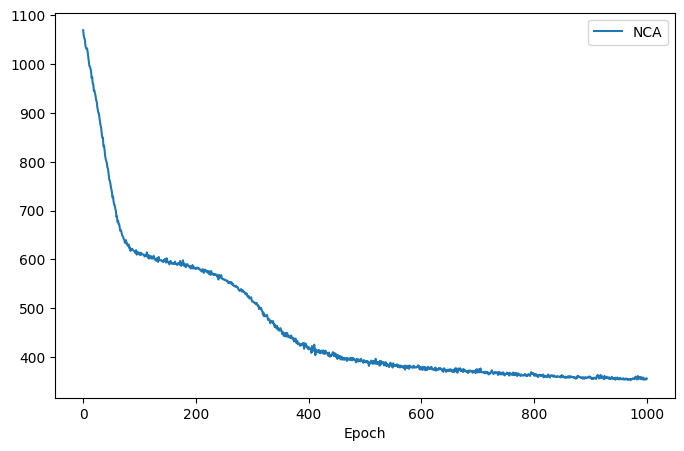

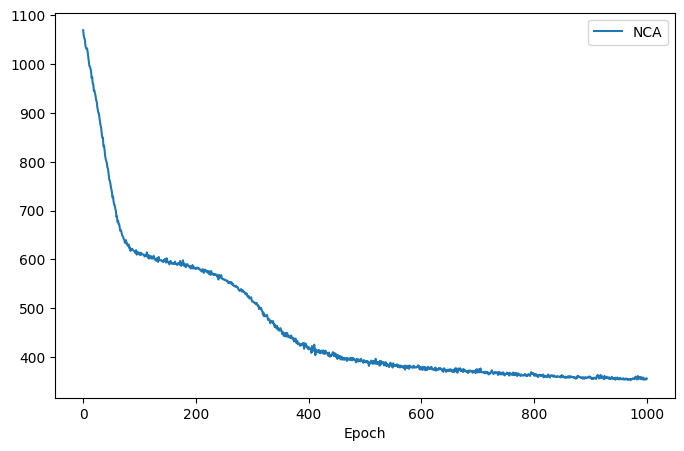

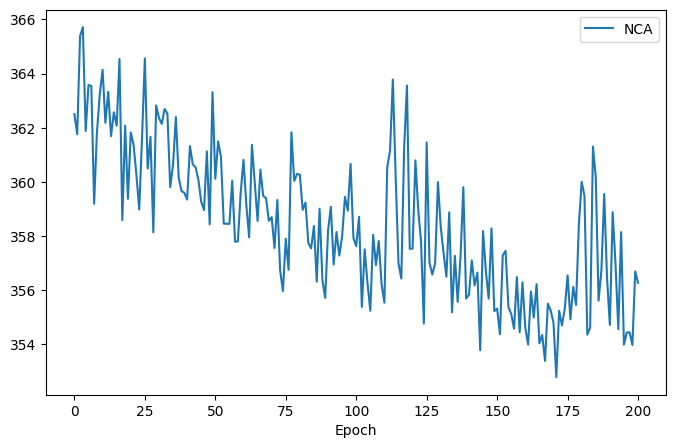

In [ ]:
def trainModelForward(ncaModel, lossDict, id, ncaSteps, epochs, optimizer, dataset):
    ncaModel.train()

    fig, ax = plt.subplots(figsize=(8, 5))
    display(fig)
    lossDict[id] = []
    loss_fn = nn.MSELoss(reduction='sum')

    for epoch in range(epochs):
        optimizer.zero_grad()

        for batch in dataset:
            batch = batch[0] # Is a list 

            timesteps = torch.linspace(ncaSteps - 1, 0, ncaSteps, device=device).long()

            x_vis = torch.randn_like(batch, device=device)
            # Use a non zero value for initialization, so the nca can differntiate between the values and padded edges
            x_hidden = torch.full((batch.shape[0], ncaModel.hiddenInputs, batch.shape[2], batch.shape[3]), 0.5, device=device)
            x_t = torch.concat((x_vis, x_hidden), dim=1)

            for t in timesteps:
                x_t = ncaModel(x_t, t)

            Loss = loss_fn(F.sigmoid(x_t[:, 0:4]), batch) / batch.shape[0]
            Loss.backward()
            optimizer.step()

            lossDict[id].append(Loss.item())
        if epoch % 10 == 0:
            clear_output(wait=True)  
            ax.clear()
            plt.plot(lossDict[id][:], label=id)
            plt.legend()
            plt.xlabel('Epoch')
            display(fig)
            
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.plot(lossDict[id][int(epochs*0.8):], label=id)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
    return model, losses

model, losses = trainModelForward(model, losses, 'NCA', diffusionSteps, 1001, Op, trainDataloader)

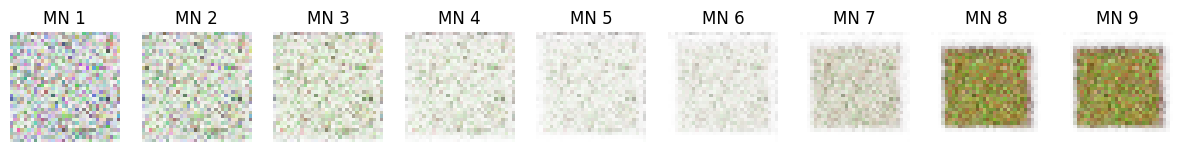

In [264]:
# Inference of trained models 
evaluatedModel = model
inferenceSteps = 8

evaluatedModel.eval()

with torch.no_grad():
    x_vis = torch.randn((1, evaluatedModel.in_out_channels, 32, 32), device=device)
    x_hidden = torch.full((1, evaluatedModel.hiddenInputs, 32, 32), 0.5, device=device)
    x_t = torch.concat((x_vis, x_hidden), dim=1)

    intermediateImages = []

    timesteps = torch.linspace(inferenceSteps - 1, 0, inferenceSteps, device=device).long()
    

    for i, t in enumerate(timesteps):
        x_t = evaluatedModel(x_t, t)

        if i % (inferenceSteps / 8)  == 0:
            intermediateImages.append(F.sigmoid(x_t).cpu().numpy())
    x_t = F.sigmoid(x_t)

    #Might be a duplicate from last step
    intermediateImages.append(x_t.cpu().numpy())

numColumns = len(intermediateImages)
fig, axs = plt.subplots(1, numColumns, figsize=(15, 3))

# Plot images
for col, img in enumerate(intermediateImages):
    axs[ col].imshow(img[0,0:4].transpose(1, 2, 0))
    axs[ col].axis('off')  
    axs[ col].set_title(f"{'MN'} {col+1}")  


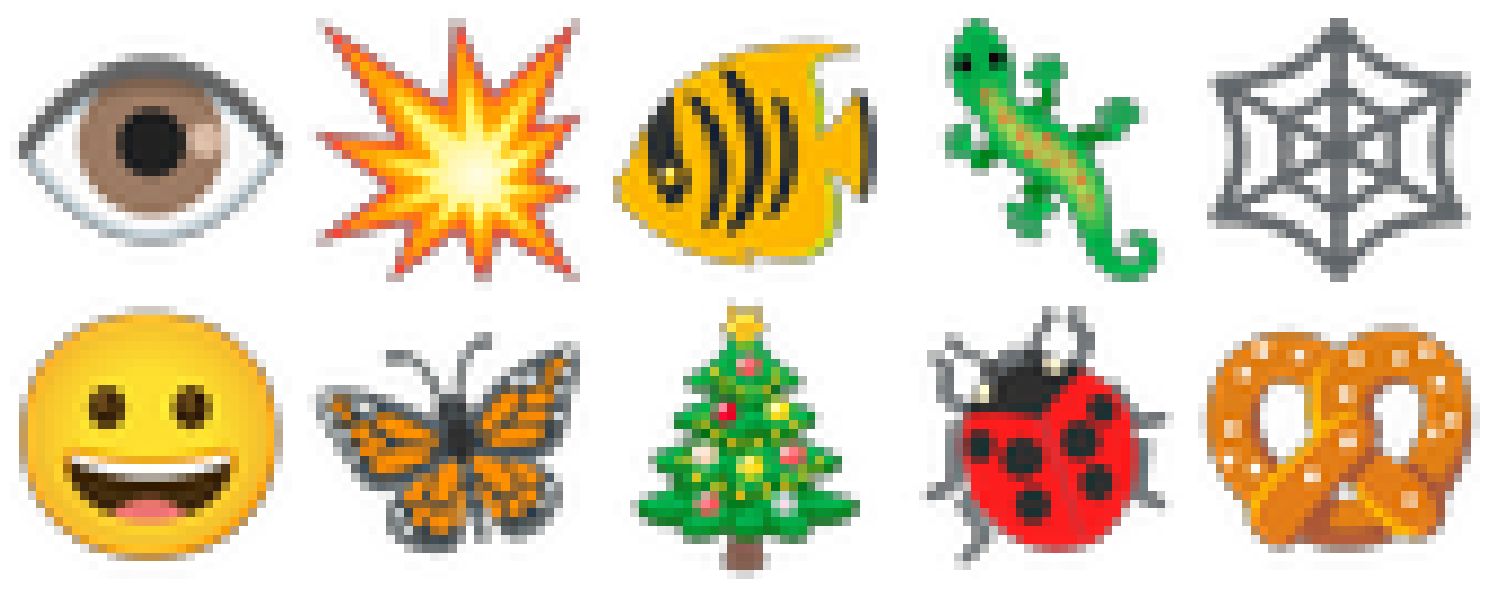

In [265]:
batch = next(iter(trainDataloader))[0]

batch_permuted = batch.permute(0, 2, 3, 1).cpu().numpy()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for ax, img in zip(axes, batch_permuted):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()